In [1]:
import csv
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import os
from collections import defaultdict
from surprise import BaselineOnly, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split

## Test on sample data

In [2]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

data = Dataset.load_builtin('ml-100k')
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9401  0.9364  0.9341  0.9384  0.9344  0.9367  0.0023  
MAE (testset)     0.7396  0.7375  0.7373  0.7402  0.7365  0.7382  0.0014  
Fit time          0.67    0.76    0.73    0.68    0.69    0.71    0.03    
Test time         0.13    0.16    0.12    0.16    0.17    0.15    0.02    


{'test_rmse': array([0.94014999, 0.93642459, 0.93408295, 0.9383508 , 0.93443023]),
 'test_mae': array([0.73959345, 0.73749852, 0.73735   , 0.74017302, 0.73648832]),
 'fit_time': (0.6667459011077881,
  0.7562968730926514,
  0.73232102394104,
  0.6842060089111328,
  0.6908578872680664),
 'test_time': (0.12873291969299316,
  0.1616687774658203,
  0.12313079833984375,
  0.1630866527557373,
  0.16676926612854004)}

## Perform SVD on my data

SVD predicts a user's rating of a given champion, accounting for their individual bias.

In [184]:
top_5 = os.path.expanduser("../data/top_5_surprise.csv")
top_25 = os.path.expanduser("../data/top_25_surprise.csv")
all_champs = os.path.expanduser('../data/all_champs_surprise.csv')
users_1000 = os.path.expanduser('../data/1000_users_all_champs_surprise.csv')
file_path = users_1000
reader = Reader(sep=",", rating_scale=(0,1))
data = Dataset.load_from_file(file_path, reader)

sim_options = {
    "name": "pearson_baseline",
    "user_based": False
}
algo = KNNWithMeans(sim_options=sim_options)
res = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(res['test_rmse'].mean())

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1203  0.1196  0.1201  0.1223  0.1205  0.1206  0.0009  
MAE (testset)     0.0544  0.0539  0.0546  0.0543  0.0543  0.0543  0.0002  
Fit time          0.43    0.49    0.44    0.50    0.44    0.46    0.03    
Test time         5.53    5.65    10.00   5.66    10

## Observe correlation of RMSE and N Factors in SVD

In [40]:
file_path = os.path.expanduser("../data/data_surprise_format.csv")
reader = Reader(sep=",", rating_scale=(0,1))
data = Dataset.load_from_file(file_path, reader)

x = np.arange(2, 161, 10)
y = np.zeros_like(x, dtype=float)


for i, n in enumerate(x):
    algo = KNNBasic(n=)
    print(n)
    y[i] = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)['test_rmse'].mean() 

2


KeyboardInterrupt: 

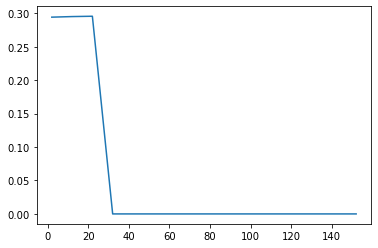

In [6]:
plt.plot(x,y)

## K-NN testing

In [185]:
file_path = os.path.expanduser("../data/data_surprise_format.csv")
reader = Reader(sep=",", rating_scale=(0,1))
data = Dataset.load_from_file(users_1000, reader)

x = np.arange(5, 40, 5)
y = np.zeros_like(x, dtype=float)

sim_options = {
    "name": "pearson_baseline",
    "user_based": False
}

for i, n in enumerate(x):
    algo = KNNWithMeans(k=n, sim_options=sim_options)
    y[i] = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)['test_rmse'].mean() 

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

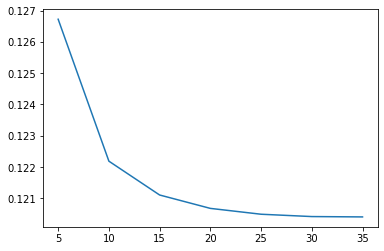

In [186]:
plt.plot(x,y)

## Test available classifiers on champion data

SVD - predict a user's rating of a given champion, accounting for their individual bias.

SVD++ - extension of SVD, accounting for implicit ratings, which accounts for the fact that a user rated item j without accouting for the given value (the user looked at this value)

Baseline - predicts baseline estimate for given user and item

Random - give a random rating based on distribution of training set

NMF - based on Non-negative Matrix Factorization, similar to SVD - algorithm highly dependent on initial values

Slope One - predict users preference for particular item based on preferences of other users

Co-clustering - users and items assigned clusters

k-NN Basic - aggregate of neighbors

Centered k-NN - aggregate of neighbors, but the mean rating of each user is accounted for

k-NN baseline - k-nn, but a baseline rating is accounted for

In [111]:
from surprise import SVD, SVDpp, BaselineOnly, NormalPredictor, NMF, SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline

sim_options = {
    "name": "pearson_baseline",
    "user_based": False
}

classifiers = [BaselineOnly(), SVD(), SVDpp(), NormalPredictor(), NMF(), SlopeOne(), CoClustering(n_cltr_u = 3, n_cltr_i = 3), KNNBasic(sim_options=sim_options), KNNWithMeans(sim_options=sim_options), KNNBaseline(sim_options=sim_options)]
labels = ['Baseline', 'SVD', 'SVDpp', 'Random', 'NMF', 'Slope One', 'Co-clustering', 'KNN', 'KNN With Means','KNN Baseline']



results = {}
for (cls, tag) in zip(classifiers, labels):
    results[tag] = cross_validate(cls, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)['test_rmse'].mean()

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using al

In [112]:
pprint.pprint(results)

{'Baseline': 0.12654687721454294,
 'Co-clustering': 0.13376078934386954,
 'KNN': 0.1218763108618913,
 'KNN Baseline': 0.12043392747279813,
 'KNN With Means': 0.12035569214101086,
 'NMF': 0.13586478179353695,
 'Random': 0.16157882556273642,
 'SVD': 0.12723143857660085,
 'SVDpp': 0.12677579393471555,
 'Slope One': 0.12887126708180224}


## Paramaterize for SVDpp

In [11]:
filename = '../data/champion.json'
with open(filename, 'r') as f:
    champ_data = json.load(f)

# contains index of championId and name
id_champ_map = {}
cols = []
for i, c in enumerate(champ_data['data'].keys()):
    id_champ_map[int(champ_data['data'][c]['key'])] = {'champion': champ_data['data'][c]['id'], 'index': i}
    cols.append(champ_data['data'][c]['id'])

In [158]:
filename = '../data/all_champs_surprise.csv'
most_played = {}

with open(filename, 'r') as f:
    reader_obj = csv.reader(f)
    cur_id = ''
    most = []
    for row in reader_obj:
        if cur_id != row[0]:
            count = 0
            if cur_id != '':
                most_played[cur_id] = most
                most = []
            cur_id = row[0]
        most.append(row[1])
        count += 1
        #else:
            #continue

In [142]:
top_5 = os.path.expanduser("../data/top_5_surprise.csv")
top_25 = os.path.expanduser("../data/top_25_surprise.csv")
all_champs = os.path.expanduser('../data/all_champs_surprise.csv')
train_set = os.path.expanduser('../data/train_data_surprise.csv')
test_set = os.path.expanduser('../data/test_data_surprise.csv')
file_path = all_champs
reader = Reader(sep=",", rating_scale=(0,1))
trainset = Dataset.load_from_file(test_set, reader)
testset = Dataset.load_from_file(train_set, reader)

sim_options = {
    "name": "pearson_baseline",
    "user_based": False
}

trainset = data.build_full_trainset()
testset = data.build_full_trainset().build_testset()
algo = KNNWithMeans(sim_options=sim_options)

algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
print(predictions)

In [ ]:
def printRec(cols, algo, n=10):
    def get_top_n(uid, cols, n):
        top_n = defaultdict(list)
        for champ in cols:
            top_n[uid].append((champ,algo.predict(uid, champ).est))
            #top_n[uid].append((champ,algo.predict(uid, champ).est/mean_rating[iid]['mean']))

        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]

        return top_n[uid]
    
    test_IDS = ['jBZi44QpCh3Ziwz30Na4rG3hT4f3dS0V7PanMs9qM_xXZTzZ', 'XmkVHqwlmKUd1JRuaWL6SshQYaIUn3-oWBDRaQDFlTQymrMG', 'h5D-yYexQgcqENJKCwm1VGjWkTdGCOz8ff2YIOB7b-VFCDvE', 'AqRWUr3C46RW6tNpOfmItiNc1fTI8ma5sBpkfJLo45kaZXEc', 'HpXI4tMjKDx3ySSN0fXBYBh3zqtvEW2xDgQG6eKyamQN9k9F', 'Ovy0KZGs2bdtLi3fddWlzRFJnQ-3KP2iIuu-1ot78uavttEw']
    for i in test_IDS:
        #pprint.pprint(most_played[i])
        print(f'Most played: {i}')
        if i in most_played.keys():
            pprint.pprint(most_played[i])
        print(f'Recommendation: {i}')
        pprint.pprint(get_top_n(i, cols, n))
        print()

In [114]:
mean_rating = {}

for rating in trainset.all_ratings():
    __, iid, rate = rating
    iid = trainset.to_raw_iid(iid)
    if iid not in mean_rating.keys():
        mean_rating[iid] = {'score': rate, 'n': 1, 'mean': rate}
    else:
        mean_rating[iid]['score'] += rate
        mean_rating[iid]['n'] += 1
        mean_rating[iid]['mean'] = mean_rating[iid]['score']/mean_rating[iid]['n']

In [115]:
pprint.pprint(mean_rating)

{'Aatrox': {'mean': 0.061113665326449504,
            'n': 1001,
            'score': 61.17477899177595},
 'Ahri': {'mean': 0.07221847988776871, 'n': 1001, 'score': 72.29069836765647},
 'Akali': {'mean': 0.12167998371870108, 'n': 1001, 'score': 121.80166370241977},
 'Akshan': {'mean': 0.01349834878782964, 'n': 1001, 'score': 13.51184713661747},
 'Alistar': {'mean': 0.01801802789739503,
             'n': 1001,
             'score': 18.036045925292424},
 'Amumu': {'mean': 0.032886173213765656, 'n': 1001, 'score': 32.91905938697942},
 'Anivia': {'mean': 0.0098739864575746, 'n': 1001, 'score': 9.883860444032173},
 'Annie': {'mean': 0.02599705540422245, 'n': 1001, 'score': 26.023052459626673},
 'Aphelios': {'mean': 0.035352227151528526,
              'n': 1001,
              'score': 35.38757937868005},
 'Ashe': {'mean': 0.10129123579892134, 'n': 1001, 'score': 101.39252703472026},
 'AurelionSol': {'mean': 0.016428833778389166,
                 'n': 1001,
                 'score': 16.445262

Prediction(uid='jBZi44QpCh3Ziwz30Na4rG3hT4f3dS0V7PanMs9qM_xXZTzZ', iid='Yasuo', r_ui=0.24, est=0.5127884837789994, details={'actual_k': 6, 'was_impossible': False})

In [94]:
def printRecommendations(algo, trainset, n=10):
    def get_top_n(predictions, n):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid,est))
            #top_n[uid].append((iid,est/mean_rating[iid]['mean']))

        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]

        return top_n

    testset = trainset.build_anti_testset(fill=0)
    predictions = algo.test(testset)

    rec = get_top_n(predictions, n)
    
    test_IDS = ['jBZi44QpCh3Ziwz30Na4rG3hT4f3dS0V7PanMs9qM_xXZTzZ', 'XmkVHqwlmKUd1JRuaWL6SshQYaIUn3-oWBDRaQDFlTQymrMG', 'h5D-yYexQgcqENJKCwm1VGjWkTdGCOz8ff2YIOB7b-VFCDvE', 'AqRWUr3C46RW6tNpOfmItiNc1fTI8ma5sBpkfJLo45kaZXEc', 'HpXI4tMjKDx3ySSN0fXBYBh3zqtvEW2xDgQG6eKyamQN9k9F', 'Ovy0KZGs2bdtLi3fddWlzRFJnQ-3KP2iIuu-1ot78uavttEw']
    for i in test_IDS:
        #pprint.pprint(most_played[i])
        print(f'Most played: {i}')
        pprint.pprint(most_played[i])
        print(f'Recommendation: {i}')
        pprint.pprint(rec[i])
        print()

In [95]:
printRecommendations(algo, trainset, 5)

Most played: jBZi44QpCh3Ziwz30Na4rG3hT4f3dS0V7PanMs9qM_xXZTzZ
[('Ezreal', 1.0),
 ('Jhin', 0.6567971558403671),
 ('Ashe', 0.2896820098991787),
 ('Kaisa', 0.24264360484377395),
 ('Varus', 0.1900276405638873),
 ('Zeri', 0.1846528117722101)]
Recommendation: jBZi44QpCh3Ziwz30Na4rG3hT4f3dS0V7PanMs9qM_xXZTzZ
[]

Most played: XmkVHqwlmKUd1JRuaWL6SshQYaIUn3-oWBDRaQDFlTQymrMG
[('Talon', 1.0),
 ('MasterYi', 0.37431040564373896),
 ('XinZhao', 0.2124620811287478),
 ('Jayce', 0.18540388007054673),
 ('Ekko', 0.1792063492063492),
 ('Jax', 0.1617636684303351)]
Recommendation: XmkVHqwlmKUd1JRuaWL6SshQYaIUn3-oWBDRaQDFlTQymrMG
[]

Most played: h5D-yYexQgcqENJKCwm1VGjWkTdGCOz8ff2YIOB7b-VFCDvE
[('Lux', 1.0),
 ('Janna', 0.98324118021236),
 ('Neeko', 0.9553310172725938),
 ('Soraka', 0.8065126975583501),
 ('Ahri', 0.606703527915056),
 ('Morgana', 0.5522581592210207)]
Recommendation: h5D-yYexQgcqENJKCwm1VGjWkTdGCOz8ff2YIOB7b-VFCDvE
[]

Most played: AqRWUr3C46RW6tNpOfmItiNc1fTI8ma5sBpkfJLo45kaZXEc
[('Warwick', 1

In [173]:
def printRec(cols, algo, n=10):
    def get_top_n(uid, cols, n):
        top_n = defaultdict(list)
        for champ in cols:
            #top_n[uid].append((champ,algo.predict(uid, champ).est))
            top_n[uid].append((champ,algo.predict(uid, champ).est/mean_rating[iid]['mean']))

        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]

        return top_n[uid]
    
    test_IDS = ['jBZi44QpCh3Ziwz30Na4rG3hT4f3dS0V7PanMs9qM_xXZTzZ', 'XmkVHqwlmKUd1JRuaWL6SshQYaIUn3-oWBDRaQDFlTQymrMG', 'h5D-yYexQgcqENJKCwm1VGjWkTdGCOz8ff2YIOB7b-VFCDvE', 'AqRWUr3C46RW6tNpOfmItiNc1fTI8ma5sBpkfJLo45kaZXEc', 'HpXI4tMjKDx3ySSN0fXBYBh3zqtvEW2xDgQG6eKyamQN9k9F', 'Ovy0KZGs2bdtLi3fddWlzRFJnQ-3KP2iIuu-1ot78uavttEw', 'iBW2XaXpV5EiN4Q3gad7iPvH_OsUUrPmJU_DOgRupxijvSky', 'qooS5-gypYBXZyohTzWCu3U-tDilF8ctYnRCMksC-ay_wIOb', 't19gUDiztyy4M5BCWino-GWRAsvdu_XT4c17ZJaREP1Rniw3', 'D_he0g8G_fNfoJZSfLCXL-Bak73E6cKNlvxo8SBP7d08SDbV']
    for i in test_IDS:
        #pprint.pprint(most_played[i])
        print(f'Most played: {i}')
        if i in most_played.keys():
            pprint.pprint(most_played[i][:5])
        print(f'Recommendation: {i}')
        count = 0
        for rec in get_top_n(i, cols, n):
            if count >= 5:
                break
            if rec[0] not in most_played[i][:5]:
                print(count+1, rec[0])
                count += 1

In [174]:
print(most_played['jBZi44QpCh3Ziwz30Na4rG3hT4f3dS0V7PanMs9qM_xXZTzZ'][:5])

['Ezreal', 'Jhin', 'Ashe', 'Kaisa', 'Varus']


In [175]:
printRec(cols, algo)

Most played: jBZi44QpCh3Ziwz30Na4rG3hT4f3dS0V7PanMs9qM_xXZTzZ
['Ezreal', 'Jhin', 'Ashe', 'Kaisa', 'Varus']
Recommendation: jBZi44QpCh3Ziwz30Na4rG3hT4f3dS0V7PanMs9qM_xXZTzZ
1 Caitlyn
2 Jinx
3 Aphelios
4 Vayne
5 Yasuo
Most played: XmkVHqwlmKUd1JRuaWL6SshQYaIUn3-oWBDRaQDFlTQymrMG
['Talon', 'MasterYi', 'XinZhao', 'Jayce', 'Ekko']
Recommendation: XmkVHqwlmKUd1JRuaWL6SshQYaIUn3-oWBDRaQDFlTQymrMG
1 Yasuo
2 Fizz
3 Kayn
4 Jax
5 Darius
Most played: h5D-yYexQgcqENJKCwm1VGjWkTdGCOz8ff2YIOB7b-VFCDvE
['Lux', 'Janna', 'Neeko', 'Soraka', 'Ahri']
Recommendation: h5D-yYexQgcqENJKCwm1VGjWkTdGCOz8ff2YIOB7b-VFCDvE
1 Morgana
2 Nami
3 Sona
4 Seraphine
5 MissFortune
Most played: AqRWUr3C46RW6tNpOfmItiNc1fTI8ma5sBpkfJLo45kaZXEc
['Warwick', 'Sejuani', 'Khazix', 'Kaisa', 'Graves']
Recommendation: AqRWUr3C46RW6tNpOfmItiNc1fTI8ma5sBpkfJLo45kaZXEc
1 Lux
2 Yasuo
3 Ezreal
4 Kayn
5 Hecarim
Most played: HpXI4tMjKDx3ySSN0fXBYBh3zqtvEW2xDgQG6eKyamQN9k9F
['Brand', 'Lux', 'Veigar', 'Morgana', 'Neeko']
Recommendation: HpXI4

In [166]:
for i in algo.get_neighbors(trainset.to_inner_iid('Jax'), 10):
    print(trainset.to_raw_iid(i))

Darius
MasterYi
Renekton
Nasus
Tryndamere
Fiora
Mordekaiser
Garen
Camille
Olaf


In [179]:
print(algo.default_prediction())

0.03696062979377657
